In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import minimize

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

# グラフを描画するライブラリ
from matplotlib import pylab as plt
import seaborn as sns

sns.set()

In [13]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option("display.width", 80)

from matplotlib.pylab import rcParams

rcParams["font.family"] = "IPAexGothic"
rcParams["figure.figsize"] = 8, 4

In [3]:
# 乱数の種
np.random.seed(1)

# 正規分布に従う乱数の累積和を作成し、ランダムウォーク系列を作る
sim_size = 100
mu = np.cumsum(stats.norm.rvs(loc=0, scale=1, size=sim_size).round(1)) + 30

# 観測値の作成
y = mu + stats.norm.rvs(loc=0, scale=5, size=sim_size).round(1)

# 時系列インデックスの付与
y_ts = pd.Series(y, index=pd.date_range(start="2020-01-01", periods=sim_size, freq="D"))

In [4]:
class LocalLevel:
    # データを格納(pd.Seriesで、日付インデックスがついている想定)
    def __init__(self, ts_data):
        self.ts_data = ts_data
        self.a = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
        self.P = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
        self.v = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
        self.F = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
        self.K = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
        self.s_level = None  # 過程誤差の分散
        self.s_irregular = None  # 観測誤差の分散

    # 状態の初期値を設定する
    def initialize(self, initial_a, initial_P):
        self.initial_a = initial_a
        self.initial_P = initial_P

    # 1時点先の予測値を計算する
    def _forecast_step(self, a_pre, P_pre, s_irregular, s_level, first=False):
        if first:
            a_forecast = self.initial_a  # 初回に限り、初期値を代入
            P_forecast = self.initial_P  # 初回に限り、初期値を代入
        else:
            a_forecast = a_pre  # 状態の予測値
            P_forecast = P_pre + s_level  # 状態の予測値の分散

        y_forecast = a_forecast  # 観測値の予測値
        F = P_forecast + s_irregular  # 観測値の予測値の残差の分散

        return pd.Series(
            [a_forecast, P_forecast, y_forecast, F], index=["a", "P", "y", "F"]
        )

    # 1時点のフィルタリングをする
    def _filter_step(self, forecasted, y, s_irregular):
        v = y - forecasted.y  # 観測値の1時点先予測値の残差
        K = forecasted.P / forecasted.F  # カルマンゲイン
        a_filter = forecasted.a + K * v  # フィルタ化推定量（更新後の状態推定値）
        P_filter = (1 - K) * forecasted.P  # フィルタ化推定量の分散（更新後の不確実性）

        return pd.Series([a_filter, P_filter, v, K], index=["a", "P", "v", "K"])

    # フィルタリングを行う
    def filter(self, s_irregular, s_level):
        for i in range(0, len(self.ts_data)):
            if i == 0:
                # 初回のみ、初期値の値を利用して予測する
                forecast_loop = self._forecast_step(
                    a_pre=None,
                    P_pre=None,
                    s_irregular=s_irregular,
                    s_level=s_level,
                    first=True,
                )
            else:
                # 2時点目以降は、1時点前の推定結果を参照して予測する
                forecast_loop = self._forecast_step(
                    a_pre=self.a.iloc[i - 1],
                    P_pre=self.P.iloc[i - 1],
                    s_irregular=s_irregular,
                    s_level=s_level,
                )

            # フィルタリングの実行（予測と観測の融合）
            filter_loop = self._filter_step(
                forecasted=forecast_loop,
                y=self.ts_data.iloc[i],
                s_irregular=s_irregular,
            )

            # 結果の保存
            self.a.iloc[i] = filter_loop.a  # 更新後の状態推定値
            self.P.iloc[i] = filter_loop.P  # 更新後の分散
            self.F.iloc[i] = forecast_loop.F  # 残差分散
            self.K.iloc[i] = filter_loop.K  # カルマンゲイン
            self.v.iloc[i] = filter_loop.v  # 観測誤差（残差）

    # 対数尤度の計算
    def llf(self):
        # 正規分布を仮定した尤度の対数和
        return np.sum(np.log(stats.norm.pdf(x=self.v, loc=0, scale=np.sqrt(self.F))))

    # パラメータの推定と状態の再当てはめ
    def fit(self, start_params):
        # 内部関数：パラメータを指定して対数尤度の-1倍を計算
        def calc_llf(params):
            self.filter(
                np.exp(params[0]), np.exp(params[1])
            )  # 対数パラメータを指数変換
            return self.llf() * -1  # 最適化では最小化を行うため、負の対数尤度を返す

        # Nelder-Mead法による最適化
        opt_res = minimize(
            calc_llf,
            start_params,
            method="Nelder-Mead",
            tol=1e-6,
            options={"maxiter": 2000},
        )

        # 推定されたパラメータの保存
        self.s_irregular = np.exp(opt_res.x[0])  # 観測誤差の分散
        self.s_level = np.exp(opt_res.x[1])  # 過程誤差の分散

        # 最適パラメータで再度フィルタリングを実行
        self.filter(self.s_irregular, self.s_level)

    # 推定された状態の可視化
    def plot_level(self):
        # 観測値とフィルタ化推定値を並べてプロット
        plot_df = pd.concat([self.a, self.ts_data], axis=1)
        plot_df.columns = ["filtered", "y"]
        plot_df.plot(title="状態推定値（filtered）と観測値（y）")

In [5]:
# データを格納
local_level = LocalLevel(y_ts)
# → LocalLevelクラスのインスタンスを作成し、対象の時系列データ（y_ts）を内部に保持する。

# 初期化
local_level.initialize(initial_a=0, initial_P=1000000)
# → 状態の初期値を設定する。
#   - initial_a : 状態（レベル）の初期推定値（ここでは0）
#   - initial_P : 状態分散（初期の不確実性を非常に大きくしている）

# フィルタリング
local_level.filter(s_irregular=10, s_level=1)
# → カルマンフィルタを適用して、各時点での状態（レベル）を推定する。
#   - s_irregular : 観測誤差の分散 (σ_ε²)
#   - s_level     : 過程誤差の分散 (σ_η²)
#
# この操作により、local_level.a（状態推定値）や local_level.v（残差）などが更新される。
# つまり、「観測値 y_t」から「真のレベル μ_t」を逐次推定する過程である。

In [6]:
# フィルタ化推定量を小数点第5位まで丸めて上位3行を表示
local_level.a.round(5).head(3)

# ▼説明
# local_level.a は「各時点におけるフィルタ化された状態推定値（level成分 μ_t）」を表す。
# これはカルマンフィルタを通して得られた「その時点までの情報を用いた最良の推定値」である。
#
# 例えば：
#   - t=1 の a₁ は、初期値と第1観測 y₁ をもとに更新された状態推定値。
#   - t=2 の a₂ は、a₁ と y₂ の情報を使って更新された推定値。
#
# この推定値系列 a_t は、観測値 y_t よりもノイズが少なく、滑らかに変化する特徴を持つ。

2020-01-01    29.39971
2020-01-02    33.43318
2020-01-03    33.07468
Freq: D, dtype: float64

In [7]:
# フィルタ化推定量の分散を小数点第5位まで丸めて上位3行を表示
local_level.P.round(5).head(3)

# ▼説明
# local_level.P は「各時点におけるフィルタ化された状態推定値 a_t の分散（不確実性）」を表す。
# これはカルマンフィルタが持つ「推定の信頼度」を数値で示しており、
# 値が小さいほど、その時点の推定値 a_t が観測値 y_t によって十分に確定していることを意味する。
#
# 一般的な挙動：
#   - 観測誤差分散 s_irregular が小さい場合 → P_t は急速に減少（推定精度が高まる）
#   - 状態誤差分散 s_level が大きい場合 → P_t は大きくなる（状態変動が激しく信頼度が低下）
#
# したがって、P_t の推移を見ることで「時系列モデルの不確実性がどのように変化しているか」を確認できる。

2020-01-01    9.99990
2020-01-02    5.23807
2020-01-03    3.84163
Freq: D, dtype: float64

In [8]:
# 観測値の1時点先予測値の残差を小数点第5位まで丸めて上位3行を表示
local_level.v.round(5).head(3)

# ▼説明
# local_level.v は「観測値の1時点先予測誤差（innovation）」を表す。
# 具体的には、以下の式で計算される：
#
#     v_t = y_t − ŷ_t|t−1
#
# ここで、
#   - y_t       : 実際の観測値（観測系列）
#   - ŷ_t|t−1  : 1時点前までの情報による観測値の予測値
#
# この v_t は、カルマンフィルタにおける「新しい情報」を意味する。
# v_t が大きい場合、その時点で予測と実際の観測値の差が大きく、
# 状態推定に強く影響を与える。
#
# なお、v_t の系列の分散は F_t（予測誤差分散）として local_level.F に保存されている。

2020-01-01    29.40000
2020-01-02     7.70029
2020-01-03    -0.93318
Freq: D, dtype: float64

In [9]:
# 観測値の1時点先予測値の残差の分散を小数点第5位まで丸めて上位3行を表示
local_level.F.round(5).head(3)

# ▼説明
# local_level.F は「観測値の1時点先予測値の残差の分散（予測誤差分散）」を表す。
# これはカルマンフィルタの更新ステップで重要な役割を持ち、
# 以下の式で定義される：
#
#     F_t = P_t|t−1 + σ_ε²
#
# ここで、
#   - P_t|t−1 : 状態（レベル成分）の1時点先予測分散
#   - σ_ε²    : 観測誤差の分散（observation noise variance）
#
# F_t は、観測された値 y_t が予測値 ŷ_t|t−1 からどれほどばらつくかを表す尺度であり、
# カルマンゲイン K_t の算出にも用いられる：
#
#     K_t = P_t|t−1 / F_t
#
# よって、F_t が大きいほど観測値の信頼性が低く、
# 状態更新（a_t の修正）に対して観測データの影響が小さくなる。

2020-01-01    1.000010e+06
2020-01-02    2.099990e+01
2020-01-03    1.623807e+01
Freq: D, dtype: float64

In [10]:
# カルマンゲインを小数点第5位まで丸めて上位3行を表示
local_level.K.round(5).head(3)

# ▼説明
# local_level.K は「カルマンゲイン（Kalman Gain）」を表す。
# カルマンゲインは、観測値 y_t に基づいて
# 状態推定値 a_t をどの程度修正すべきかを決める重みであり、
# 以下の式で定義される：
#
#     K_t = P_t|t−1 / F_t
#
# ここで、
#   - P_t|t−1 : 状態（レベル成分）の1時点先予測分散
#   - F_t      : 観測値の予測誤差分散（= P_t|t−1 + σ_ε²）
#
# K_t の値が大きい場合：
#   → 観測値の信頼性が高く、観測値を強く反映して状態を修正する。
#
# K_t の値が小さい場合：
#   → モデル（予測）の信頼性が高く、観測値による修正は小さくなる。
#
# したがって、K_t はカルマンフィルタの「観測とモデルのバランス」を
# 動的に調整する重要なパラメータである。

2020-01-01    0.99999
2020-01-02    0.52381
2020-01-03    0.38416
Freq: D, dtype: float64

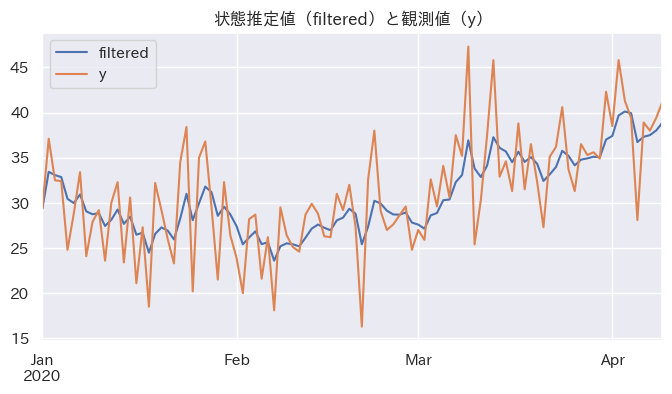

In [14]:
# 推定された状態（フィルタ化推定量）の可視化
local_level.plot_level()

# ▼説明
# この関数では、推定された状態（a_t: filtered state）と実際の観測値（y_t）を
# 同じグラフ上に重ねて描画する。
#
# - 青線（y）：観測値（実際のデータ）
# - オレンジ線（filtered）：フィルタによって推定された「真の状態（レベル）」の時系列
#
# 状態空間モデルの文脈では、観測値 y_t は次のように表される：
#
#     y_t = a_t + ε_t
#
# （ε_t は観測誤差）
#
# 一方、状態 a_t は以下のように時系列的に変化する：
#
#     a_t = a_{t-1} + η_t
#
# （η_t は過程誤差）
#
# このプロットを通して、
# - 観測値 y_t がノイズを含む実データであるのに対し、
# - フィルタ化推定量 a_t はその背後にある滑らかなトレンド（潜在状態）を表していることが確認できる。
#
# よって、このグラフはカルマンフィルタの推定結果を直感的に理解する上で重要である。